## Visual Quality Control Inspections

**Improve Automated Inspection with Computer Vision**

A model that classifies images as 'Good' / 'Anomaly'. Trained without any labels for defective regions, model in the inference mode is able to predict a bounding box for a defective region in the image. This is achieved by processing feature maps of the deep convolutional layers. AI-powered systems can inspect products for defects with a high degree of accuracy, which can help to reduce the number of defective products that are produced. 

### Visual Quality Control Inspections as a AI for Manufacturing Usecase:

**Automating visual quality control inspections for life sciences can be considered as a use case of AI in manufacturing. In life sciences, AI-powered visual quality control inspections involve using computer vision algorithms to analyze images and video of products, such as drugs, medical devices, and biologics, in order to identify defects, contaminants, or other issues that may affect product quality.**

## AI Project Cycle ![AI_Project_Cycle.png](docs/AI_Project_Cycle.jpg)

## Context: Understanding the Problem Statement --------Problem Scoping (AI Project Cycle - Step 1)

**An Deep Learning based classification solution for Defect Detection Using Convolutional Neural Networks**

- In the manufacturing of life sciences products, visual quality control inspections are an important step in ensuring that products meet the necessary standards for safety and efficacy. AI-based visual inspection systems can help to automate this process by analyzing images and videos of products in real-time, identifying defects, and flagging any issues that may arise. This can help to improve the speed and accuracy of visual inspections, and ensure that only high-quality products reach the market.

- Additionally, AI-based visual inspection systems can also be used to monitor the manufacturing process, identifying any issues that may arise during production and helping to prevent defects from occurring in the first place. Overall, automating visual quality control inspections for life sciences is a good example of AI in manufacturing usecase which helps to improve the overall quality and safety of life sciences products.


### Import the useful Packages & Libraries

To know more about the pytorch click [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

To know more about OS module click [here](https://www.geeksforgeeks.org/os-module-python-examples/)

To know more about what is Seaborn click [here](https://seaborn.pydata.org/tutorial.html)

To know more about matrices and scoring click [here](https://scikit-learn.org/stable/modules/model_evaluation.html)

To know more about warnings click [here](https://docs.python.org/3/library/warnings.html#:~:text=Warning%20messages%20are%20typically%20issued,program%20uses%20an%20obsolete%20module.)

In [20]:
# Import the os module to perform operating system-related tasks
import os

# Import the NumPy library for numerical computing
import numpy as np

# Import the PIL library for image manipulation
from PIL import Image

# Import the PyTorch library for deep learning
import torch

# Import PyTorch's data loading utilities
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# Import PyTorch's image transformation utilities
from torchvision import transforms

# Import scikit-learn's utilities for splitting data into train/test sets and for k-fold cross-validation
from sklearn.model_selection import train_test_split, StratifiedKFold

# Import the Matplotlib library for plotting
import matplotlib.pyplot as plt

# Import Matplotlib's Rectangle object for drawing bounding boxes
from matplotlib.patches import Rectangle

# Import the Seaborn library for visualization
import seaborn as sns

# Import scikit-learn's utilities for evaluating classification performance
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

# Define a constant string variable for the name of the folder containing the "good" class images
GOOD_CLASS_FOLDER = "good"

# Define a constant list variable for the dataset splits
DATASET_SETS = ["train", "test"]

# Define a constant string variable for the format of the image files
IMG_FORMAT = ".png"

# Define a constant tuple variable for the size of the input images
INPUT_IMG_SIZE = (224, 224)

# Define a constant integer variable for the negative class label
NEG_CLASS = 1

# Import the warnings module to suppress warnings in the code
import warnings

# Ignore all warnings that may be raised during the code execution
warnings.filterwarnings("ignore")


## Dataset:  Data Acquisition (AI Project Cycle - Step 2)

Dataset used - [MVTEC Anomaly Detection Dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad). This dataset is released under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0), which means it is not allowed to use it for commertial purposes.

This MVTec anomaly detection dataset (MVTec AD) is built with data derived from augmentation techniques, such as histogram equalization, letter box, random perspective, flip, scaling, and rotation. 

DataSet: https://www.mvtec.com/company/research/datasets/mvtec-ad (only download Leather dataset for this use case)

### Data preparation

The leather dataset is downloaded and extracted in a folder before running the training python module.

The dataset available from the source requires a filtering before the training. Assuming the leather dataset is downloaded from the dataset source given above in this document, Follow the below steps to filter the dataset extracted from the source.

<code>tar -xf leather.tar.xz</code>
 
<code>mkdir -p data/{train/{good,bad},test/{good,bad}}</code>   
    
<code>cd leather/train/good/
 cp $(ls | head -n 210) ../../../data/train/good/
 cp $(ls | tail -n 65) ../../../data/test/good/ 
</code>
 
<code>cd leather/test/combined
 cp $(ls | head -n 17) ../../../data/train/bad/
 cp $(ls | tail -n 5) ../../../data/test/bad/
</code>

![overview_dataset](docs/overview_dataset.jpg)

## Data Preprocessing ------ Data Exploration(AI Project Cycle - Step 3)

Data exploration is performed to gather information on data and based on the gaind insights, various pre-processing functions are implemented. 


Here, A custom dataset class, called MVTEC_AD_DATASET has been defined that is meant to be used with the MVTEC Anomaly Detection dataset. The dataset contains images and associated labels, which can be used to train and evaluate machine learning models.

The class inherits from the PyTorch Dataset class and implements several methods to allow it to be used with PyTorch's data loading and processing tools. 
The __init__ method sets up the class by defining some parameters, such as the class labels, which are either "Good" and "Anomaly". 

To know more about how to create classes click [here](https://docs.python.org/3/tutorial/classes.html) where as for learning how to create functions click [here](https://www.w3schools.com/python/python_functions.asp)

In [21]:
class MVTEC_AD_DATASET(Dataset):
    """
    Class to load subsets of MVTEC ANOMALY DETECTION DATASET
    Dataset Link: https://www.mvtec.com/company/research/datasets/mvtec-ad
    
    Root is path to the subset, for instance, `mvtec_anomaly_detection/leather`
    """

    def __init__(self, root):
        # Define the class labels based on the NEG_CLASS setting.
        self.classes = ["Good", "Anomaly"] if NEG_CLASS == 1 else ["Anomaly", "Good"]
        # Define the image transformation pipeline.
        self.img_transform = transforms.Compose(
            [transforms.Resize(INPUT_IMG_SIZE), transforms.ToTensor()]
        )

        # Load the image filenames and labels for the dataset.
        (
            self.img_filenames,
            self.img_labels,
            self.img_labels_detailed,
        ) = self._get_images_and_labels(root)

    def _get_images_and_labels(self, root):
        # Initialize lists to store image filenames and labels.
        image_names = []
        labels = []
        labels_detailed = []

        # Loop over the dataset sets (e.g., "train", "test") and classes ("good" and "anomaly").
        for folder in DATASET_SETS:
            # Construct the path to the class folder.
            folder = os.path.join(root, folder)

            # Loop over the class folders in the dataset.
            for class_folder in os.listdir(folder):
                # Determine the label for the class based on its folder name.
                label = (
                    1 - NEG_CLASS if class_folder == GOOD_CLASS_FOLDER else NEG_CLASS
                )
                # Store the detailed label (i.e., the class folder name).
                label_detailed = class_folder

                # Construct the path to the class image folder.
                class_folder = os.path.join(folder, class_folder)
                # Get the list of image filenames in the class folder that match the IMG_FORMAT setting.
                class_images = os.listdir(class_folder)
                class_images = [
                    os.path.join(class_folder, image)
                    for image in class_images
                    if image.find(IMG_FORMAT) > -1
                ]

                # Add the class image filenames and labels to the respective lists.
                image_names.extend(class_images)
                labels.extend([label] * len(class_images))
                labels_detailed.extend([label_detailed] * len(class_images))

        # Print some statistics about the dataset.
        print(
            "Dataset {}: N Images = {}, Share of anomalies = {:.3f}".format(
                root, len(labels), np.sum(labels) / len(labels)
            )
        )
        # Return the lists of image filenames and labels.
        return image_names, labels, labels_detailed

    def __len__(self):
        # Return the length of the dataset (i.e., the number of images).
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Get the filename and label for the image at the specified index.
        img_fn = self.img_filenames[idx]
        label = self.img_labels[idx]
        # Open the image file and apply the image transformation pipeline.
        img = Image.open(img_fn)
        img = self.img_transform(img)
        # Convert the label to a PyTorch tensor.
        label = torch.as_tensor(label, dtype=torch.long)
        # Return the transformed image and label as a tuple.
        return img, label

To know more about the init function click [here](https://www.geeksforgeeks.org/__init__-in-python/)

### Splitting and Loading dataset into separate training and test set

80% of the data has been used for training and 20% is used for testing. The resulting train and test sets are loaded into PyTorch DataLoaders with the specified batch size.

The *get_cv_train_test_loaders* function splits the dataset into train and test sets for N-Fold cross-validation.

In [22]:
# This function takes in the root directory of the MVTEC_AD dataset, batch size for DataLoader, test_size, and random_state as input arguments.
def get_train_test_loaders(root, batch_size, test_size=0.2, random_state=42):
    """
    Returns train and test dataloaders.
    Splits dataset in stratified manner, considering various defect types.
    """
    # Initialize the dataset object with the given root directory.
    dataset = MVTEC_AD_DATASET(root=root)

    # Split the indices of dataset into train and test sets in a stratified manner based on the defect types.
    train_idx, test_idx = train_test_split(
        np.arange(dataset.__len__()),
        test_size=test_size,
        shuffle=True,
        stratify=dataset.img_labels_detailed,
        random_state=random_state,
    )

    # Initialize the SubsetRandomSampler for the training set and test set.
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Initialize the DataLoader objects for the training set and test set with the SubsetRandomSampler.
    train_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True
    )
    test_loader = DataLoader(
        dataset, batch_size=batch_size, sampler=test_sampler, drop_last=False
    )

    # Return the DataLoader objects for the training set and test set.
    return train_loader, test_loader


# This function takes in the root directory of the MVTEC_AD dataset, batch size for DataLoader, and n_folds as input arguments.
def get_cv_train_test_loaders(root, batch_size, n_folds=5):
    """
    Returns train and test dataloaders for N-Fold cross-validation.
    Splits dataset in stratified manner, considering various defect types.
    """
    # Initialize the dataset object with the given root directory.
    dataset = MVTEC_AD_DATASET(root=root)

    # Initialize the StratifiedKFold object for the specified number of folds.
    kf = StratifiedKFold(n_splits=n_folds)

    # Initialize an empty list for storing the DataLoader objects for each fold.
    kf_loader = []

    # Split the dataset into train and test sets for each fold using the StratifiedKFold object.
    for train_idx, test_idx in kf.split(
        np.arange(dataset.__len__()), dataset.img_labels_detailed
    ):
        # Initialize the SubsetRandomSampler for the training set and test set.
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(test_idx)

        # Initialize the DataLoader objects for the training set and test set with the SubsetRandomSampler.
        train_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True
        )
        test_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=test_sampler, drop_last=False
        )

        # Append the DataLoader objects for the current fold to the list.
        kf_loader.append((train_loader, test_loader))

    # Return the list of DataLoader objects for all folds.
    return kf_loader

## Building a Model ------ Modeling ( AI Project Cycle - Step 4)

Modeling is the fourth step in the AI project cycle, which involves building a machine learning model to solve a particular problem. This step is where we use the pre-processed data to train a model that can predict the desired outcome. 

Here, a function called "train" has been defined that trains a machine learning model. The function takes several arguments and trains the model by looping over the training data in dataloader for epochs number of times. In each epoch, the model makes predictions on the inputs, calculates the loss between the predictions and the actual labels, and optimizes its parameters based on the loss gradient. The running loss and accuracy are calculated and displayed at the end of each epoch.








In [23]:
# This function takes in the dataloader (for loading training data), the model, optimizer, loss criterion, number of epochs, device to train the model on (CPU or GPU), and an optional target accuracy to stop training early.
def train(
    dataloader, model, optimizer, criterion, epochs, device, target_accuracy=None
):
    """
    Script to train a model. Returns trained model.
    """

    # These lines move the model to the specified device (CPU or GPU) and puts the model in train mode.
    model.to(device)
    model.train()

    # This loop iterates over the number of epochs specified and initializes variables to track loss, accuracy, and number of samples processed during training
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}:", end=" ")
        running_loss = 0
        running_corrects = 0
        n_samples = 0

        # This inner loop iterates over batches of data from the dataloader, moves the inputs and labels to the specified device, performs forward and backward passes through the model, calculates the loss and updates the model weights via the optimizer, and updates the running loss and accuracy statistics.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds_scores = model(inputs)
            preds_class = torch.argmax(preds_scores, dim=-1)
            loss = criterion(preds_scores, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds_class == labels)
            n_samples += inputs.size(0)

        
        # This code calculates the average loss and accuracy over the epoch and prints the results. If a target accuracy is specified, the code checks if the current epoch's accuracy exceeds the target and stops training early if it does.
        epoch_loss = running_loss / n_samples
        epoch_acc = running_corrects.double() / n_samples
        print("Loss = {:.4f}, Accuracy = {:.4f}".format(epoch_loss, epoch_acc))

        if target_accuracy != None:
            if epoch_acc > target_accuracy:
                print("Early Stopping")
                break

    # This function returns the trained model.
    return model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

# Set input image size
INPUT_IMG_SIZE = (224, 224)

class CustomVGG(nn.Module):
    """
    Custom multi-class classification model 
    with VGG16 feature extractor, pretrained on ImageNet
    and custom classification head.
    Parameters for the first convolutional blocks are freezed.
    
    Returns class scores when in train mode.
    Returns class probs and normalized feature maps when in eval mode.
    """

    def __init__(self, n_classes=2):
        super(CustomVGG, self).__init__()

        # Load VGG16 feature extractor, pretrained on ImageNet
        self.feature_extractor = models.vgg16(pretrained=True).features[:-1]

        # Define custom classification head
        self.classification_head = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(
                kernel_size=(INPUT_IMG_SIZE[0] // 2 ** 5, INPUT_IMG_SIZE[1] // 2 ** 5)
            ),
            nn.Flatten(),
            nn.Linear(
                in_features=self.feature_extractor[-2].out_channels,
                out_features=n_classes,
            ),
        )

        # Freeze parameters for the first convolutional blocks of the feature extractor
        self._freeze_params()

    def _freeze_params(self):
        # Loop through all parameters for the first 23 convolutional blocks
        for param in self.feature_extractor[:23].parameters():
            # Freeze parameters
            param.requires_grad = False

    def forward(self, x):
        # Compute feature maps using VGG16 feature extractor
        feature_maps = self.feature_extractor(x)

        # Compute class scores using custom classification head
        scores = self.classification_head(feature_maps)

        # If in training mode, return class scores
        if self.training:
            return scores

        # If in evaluation mode, return class probabilities and normalized feature maps
        else:
            # Compute class probabilities from class scores using softmax activation function
            probs = nn.functional.softmax(scores, dim=-1)

            # Compute normalized feature maps from classification head weights and feature maps
            weights = self.classification_head[3].weight
            weights = (
                weights.unsqueeze(-1)
                .unsqueeze(-1)
                .unsqueeze(0)
                .repeat(
                    (
                        x.size(0),
                        1,
                        1,
                        INPUT_IMG_SIZE[0] // 2 ** 4,
                        INPUT_IMG_SIZE[0] // 2 ** 4,
                    )
                )
            )
            feature_maps = feature_maps.unsqueeze(1).repeat((1, probs.size(1), 1, 1, 1))
            location = torch.mul(weights, feature_maps).sum(axis=2)
            location = F.interpolate(location, size=INPUT_IMG_SIZE, mode="bilinear")

            # Normalize feature maps to range [0, 1]
            maxs, _ = location.max(dim=-1, keepdim=True)
            maxs, _ = maxs.max(dim=-2, keepdim=True)
            mins, _ = location.min(dim=-1, keepdim=True)
            mins, _ = mins.min(dim=-2, keepdim=True)
            norm_location = (location - mins) / (maxs - mins)

            # Return class probabilities and normalized feature maps
            return probs, norm_location

## Evaluating the Model ------- Evaluation (AI Project Cycle - Step 5)

Evaluation of an AI project refers to the process of evaluating the performance of a model on a test set after it has been trained. The purpose of evaluation is to assess the model's ability to generalize to unseen data and to estimate its accuracy in terms of relevant metrics.






Here,the confusion matrix is generated.                                                                                                                                                       It takes as inputs the true labels (*y_true*) and the predicted labels (*y_pred*) of the test data, and an optional argument class_names which provides the names of the classes. The function uses confusion_matrix from scikit-learn to compute the confusion matrix between the true and predicted labels. It then plots the confusion matrix using sns.heatmap from the seaborn library. The plot shows the actual labels on the y-axis and the predicted labels on the x-axis. The color of each cell represents the count of samples that belong to the class in the corresponding row and column.                                                                         The x and y axis labels, title and the figure size are set. Finally, the function displays the plot using *plt.show()*.

In [25]:
def evaluate(model, dataloader, device):
    """
    Script to evaluate a model after training.
    Outputs accuracy and balanced accuracy, draws confusion matrix.
    """
    # Move the model to the specified device
    model.to(device)
    # Set the model to evaluation mode
    model.eval()
    # Get the class names from the dataloader's dataset
    class_names = dataloader.dataset.classes

    # Initialize variables to keep track of correct predictions, true labels, and predicted labels
    running_corrects = 0
    y_true = np.empty(shape=(0,))
    y_pred = np.empty(shape=(0,))

    # Loop through the dataloader's batches
    for inputs, labels in dataloader:
        # Move the inputs and labels to the specified device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass the inputs through the model and get the predicted probabilities and classes
        preds_probs = model(inputs)[0]
        preds_class = torch.argmax(preds_probs, dim=-1)

        # Move the labels and predicted classes to the CPU and convert them to numpy arrays
        labels = labels.to("cpu").numpy()
        preds_class = preds_class.detach().to("cpu").numpy()

        # Concatenate the true labels and predicted labels to the respective arrays
        y_true = np.concatenate((y_true, labels))
        y_pred = np.concatenate((y_pred, preds_class))

    # Calculate the accuracy and balanced accuracy scores using scikit-learn's metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    # Print the accuracy and balanced accuracy scores
    print("Accuracy: {:.4f}".format(accuracy))
    print("Balanced Accuracy: {:.4f}".format(balanced_accuracy))
    print()
    # Plot the confusion matrix using seaborn's heatmap function
    plot_confusion_matrix(y_true, y_pred, class_names=class_names)


def plot_confusion_matrix(y_true, y_pred, class_names="auto"):
    # Calculate the confusion matrix using scikit-learn's metrics
    confusion = confusion_matrix(y_true, y_pred)
    # Create a new figure with a specified size
    plt.figure(figsize=[5, 5])
    # Plot the confusion matrix as a heatmap using seaborn's heatmap function
    sns.heatmap(
        confusion,
        annot=True,
        cbar=False,
        xticklabels=class_names,
        yticklabels=class_names,
    )

    # Set the labels and title of the plot
    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.title("Confusion Matrix")
    # Display the plot
    plt.show()
    
    
def get_bbox_from_heatmap(heatmap, thres=0.8):
    """
    Returns bounding box around the defected area:
    Upper left and lower right corner.

    Threshold affects size of the bounding box.
    The higher the threshold, the wider the bounding box.
    """
    # Create a binary map by thresholding the heatmap
    binary_map = heatmap > thres

    # Compute the x-coordinate of the left and right edge of the bounding box
    x_dim = np.max(binary_map, axis=0) * np.arange(0, binary_map.shape[1])
    x_0 = int(x_dim[x_dim > 0].min())
    x_1 = int(x_dim.max())

    # Compute the y-coordinate of the top and bottom edge of the bounding box
    y_dim = np.max(binary_map, axis=1) * np.arange(0, binary_map.shape[0])
    y_0 = int(y_dim[y_dim > 0].min())
    y_1 = int(y_dim.max())

    # Return the four corners of the bounding box
    return x_0, y_0, x_1, y_1


# The function shows the image, its true label, predicted label and predicted probability. 
# If the model predicts an anomaly, the function draws a bounding box (bbox) around the defected region and a heatmap.
# The plot displays the images in a grid, with each image and its label/prediction information in one subplot. 
def predict_localize(
    model, dataloader, device, thres=0.8, n_samples=9, show_heatmap=False
):
    """
    Runs predictions for the samples in the dataloader.
    Shows image, its true label, predicted label and probability.
    If an anomaly is predicted, draws bbox around defected region and heatmap.
    """

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    # Get class names from dataloader
    class_names = dataloader.dataset.classes
    
    # Convert PyTorch tensor to PIL Image for displaying images
    transform_to_PIL = transforms.ToPILImage()

    # Calculate number of rows and columns for subplot visualization
    n_cols = 3
    n_rows = int(np.ceil(n_samples / n_cols))
    
    # Set figure size
    plt.figure(figsize=[n_cols * 5, n_rows * 5])

    # Initialize sample counter
    counter = 0
    
    # Iterate over batches in dataloader
    for inputs, labels in dataloader:
        
        # Move batch to device
        inputs = inputs.to(device)
        
        # Generate predictions and feature maps from model
        out = model(inputs)
        probs, class_preds = torch.max(out[0], dim=-1)
        feature_maps = out[1].to("cpu")

        # Iterate over images in batch
        for img_i in range(inputs.size(0)):
            
            # Get image, predicted label, probability, and true label
            img = transform_to_PIL(inputs[img_i])
            class_pred = class_preds[img_i]
            prob = probs[img_i]
            label = labels[img_i]
            
            # Get heatmap for negative class (anomaly) if predicted
            heatmap = feature_maps[img_i][NEG_CLASS].detach().numpy()

            # Increment subplot counter
            counter += 1
            
            # Create subplot for image
            plt.subplot(n_rows, n_cols, counter)
            
            # Show image and set axis off
            plt.imshow(img)
            plt.axis("off")
            
            # Set title with predicted label, probability, and true label
            plt.title(
                "Predicted: {}, Prob: {:.3f}, True Label: {}".format(
                    class_names[class_pred], prob, class_names[label]
                )
            )

            # If anomaly is predicted (negative class)
            if class_pred == NEG_CLASS:
                
                # Get bounding box from heatmap and draw rectangle around anomaly
                x_0, y_0, x_1, y_1 = get_bbox_from_heatmap(heatmap, thres)
                rectangle = Rectangle(
                    (x_0, y_0),
                    x_1 - x_0,
                    y_1 - y_0,
                    edgecolor="red",
                    facecolor="none",
                    lw=3,
                )
                plt.gca().add_patch(rectangle)
                
                # If show_heatmap is True, show heatmap
                if show_heatmap:
                    plt.imshow(heatmap, cmap="Reds", alpha=0.3)

            # If counter equals number of samples, show plot and return
            if counter == n_samples:
                plt.tight_layout()
                plt.show()
                return 

## Model Deployment Over the Test Dataset ------- Deployment (AI Project Cycle - Step 6)

### Parameters to run the functions defined above

In [26]:
# Setting up the data folder path to "data/leather".


# Setting up batch size, target accuracy, learning rate, number of epochs, and class weights.
batch_size = 10
target_train_accuracy = 0.98
lr = 0.0001
epochs = 10
class_weight = [1, 3] if NEG_CLASS == 1 else [3, 1]

# Determining the device to use for training, either cuda or cpu.

# Setting up the threshold value to use for the heatmap and the number of cross-validation folds.


### Loading the Data

 Two data loaders for training and testing data are created. 

*root*, *batch_size*, *test_size* and *random_state* are the four parameters used here.
 The returned data loaders will be used to feed the data to the model for training and evaluation.

In [27]:
train_loader, test_loader = get_train_test_loaders(
    root=data_folder, batch_size=batch_size, test_size=0.2, random_state=42,
)

Dataset data/leather: N Images = 369, Share of anomalies = 0.249


### Model Training
Model training is the process of using a set of training data to learn the parameters of a machine learning model. The goal of model training is to find a set of parameters that minimize the difference between the model's predictions and the true target values in the training data.

Here, we initialized and set up components for training the model using Pytorch.

In [28]:
# Create a new instance of the CustomVGG model and assign it to the variable 'model'.
model = CustomVGG()

# Convert the class_weight list to a tensor of type FloatTensor and move it to the device (GPU/CPU) specified by 'device'.
class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)

# Define the Cross Entropy Loss function with the computed class weights and assign it to the variable 'criterion'.
criterion = nn.CrossEntropyLoss(weight=class_weight)

# Define the Adam optimizer with the specified learning rate 'lr' and the model's parameters, and assign it to the variable 'optimizer'.
optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
# Initialize the training process using the train() function with the train_loader, model, optimizer, criterion, epochs, device, and target_train_accuracy parameters.
model = train(
    train_loader, model, optimizer, criterion, epochs, device, target_train_accuracy
)

Epoch 1/10: Loss = 0.5301, Accuracy = 0.8103
Epoch 2/10: Loss = 0.2289, Accuracy = 0.9069
Epoch 3/10: Loss = 0.1269, Accuracy = 0.9414
Epoch 4/10: Loss = 0.1669, Accuracy = 0.9483
Epoch 5/10: Loss = 0.1415, Accuracy = 0.9448
Epoch 6/10: Loss = 0.1153, Accuracy = 0.9379
Epoch 7/10: Loss = 0.0748, Accuracy = 0.9724
Epoch 8/10: Loss = 0.0520, Accuracy = 0.9828
Early Stopping


In [30]:
# Save the trained model to the specified path.


### Evaluation

Accuracy: 0.9595
Balanced Accuracy: 0.9211



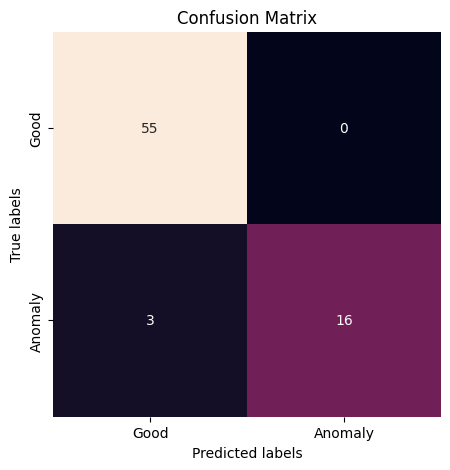

In [31]:
# Evaluate the performance of the trained model using the evaluate() function with the test_loader and device parameters.
evaluate(model, test_loader, device)

### Cross Validation
Cross validation is a technique used in machine learning to evaluate the performance of a model by dividing the dataset into subsets, training the model on one subset and testing it on another subset.

Pytorch library has been used here to perform cross validation for training and evaluating the model. 

Overall, we have trained a custom VGG model and evaluated its performance using a cross-validation procedure, where the performance is estimated by averaging over multiple trials with different training and testing sets.

Dataset data/leather: N Images = 369, Share of anomalies = 0.249
Fold 1/5
Epoch 1/10: Loss = 0.5947, Accuracy = 0.7069
Epoch 2/10: Loss = 0.3369, Accuracy = 0.8621
Epoch 3/10: Loss = 0.1774, Accuracy = 0.9241
Epoch 4/10: Loss = 0.1382, Accuracy = 0.9345
Epoch 5/10: Loss = 0.1608, Accuracy = 0.9379
Epoch 6/10: Loss = 0.1196, Accuracy = 0.9172
Epoch 7/10: Loss = 0.0721, Accuracy = 0.9759
Epoch 8/10: Loss = 0.1466, Accuracy = 0.9448
Epoch 9/10: Loss = 0.1270, Accuracy = 0.9517
Epoch 10/10: Loss = 0.0634, Accuracy = 0.9759
Accuracy: 0.9865
Balanced Accuracy: 0.9722



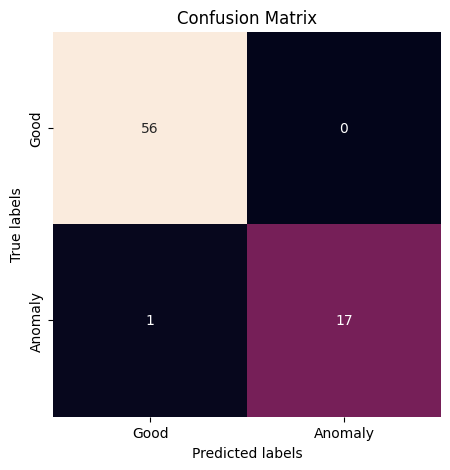

Fold 2/5
Epoch 1/10: Loss = 0.5726, Accuracy = 0.8000
Epoch 2/10: Loss = 0.2573, Accuracy = 0.9034
Epoch 3/10: Loss = 0.1665, Accuracy = 0.9241
Epoch 4/10: Loss = 0.1069, Accuracy = 0.9586
Epoch 5/10: Loss = 0.1508, Accuracy = 0.9552
Epoch 6/10: Loss = 0.0712, Accuracy = 0.9621
Epoch 7/10: Loss = 0.0828, Accuracy = 0.9621
Epoch 8/10: Loss = 0.1516, Accuracy = 0.9552
Epoch 9/10: Loss = 0.0725, Accuracy = 0.9759
Epoch 10/10: Loss = 0.0239, Accuracy = 0.9931
Accuracy: 0.9459
Balanced Accuracy: 0.8889



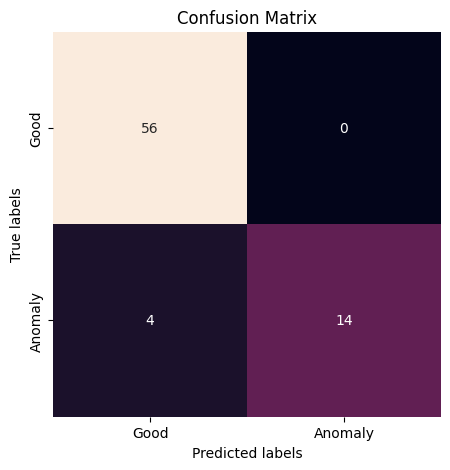

Fold 3/5
Epoch 1/10: Loss = 0.5846, Accuracy = 0.7966
Epoch 2/10: Loss = 0.3024, Accuracy = 0.8483
Epoch 3/10: Loss = 0.1659, Accuracy = 0.9069
Epoch 4/10: Loss = 0.1415, Accuracy = 0.9069
Epoch 5/10: Loss = 0.1017, Accuracy = 0.9483
Epoch 6/10: Loss = 0.1264, Accuracy = 0.9310
Epoch 7/10: Loss = 0.0881, Accuracy = 0.9621
Epoch 8/10: Loss = 0.0750, Accuracy = 0.9690
Epoch 9/10: Loss = 0.0531, Accuracy = 0.9759
Epoch 10/10: Loss = 0.0520, Accuracy = 0.9759
Accuracy: 0.9730
Balanced Accuracy: 0.9474



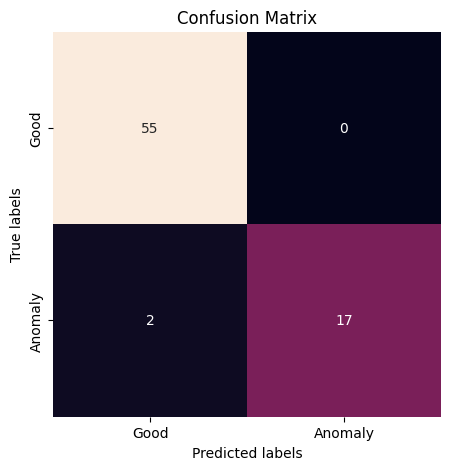

Fold 4/5
Epoch 1/10: Loss = 0.5699, Accuracy = 0.6862
Epoch 2/10: Loss = 0.3179, Accuracy = 0.9034
Epoch 3/10: Loss = 0.2061, Accuracy = 0.9345
Epoch 4/10: Loss = 0.1422, Accuracy = 0.9483
Epoch 5/10: Loss = 0.1293, Accuracy = 0.9448
Epoch 6/10: Loss = 0.0977, Accuracy = 0.9621
Epoch 7/10: Loss = 0.0916, Accuracy = 0.9552
Epoch 8/10: Loss = 0.1028, Accuracy = 0.9621
Epoch 9/10: Loss = 0.0942, Accuracy = 0.9655
Epoch 10/10: Loss = 0.0559, Accuracy = 0.9828
Accuracy: 0.9730
Balanced Accuracy: 0.9474



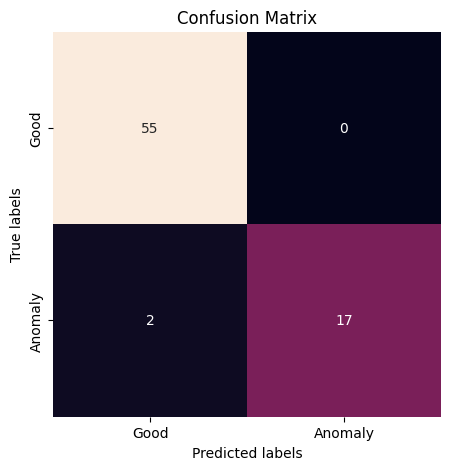

Fold 5/5
Epoch 1/10: Loss = 0.5916, Accuracy = 0.7586
Epoch 2/10: Loss = 0.1958, Accuracy = 0.9483
Epoch 3/10: Loss = 0.0788, Accuracy = 0.9759
Epoch 4/10: Loss = 0.0528, Accuracy = 0.9862
Epoch 5/10: Loss = 0.0327, Accuracy = 0.9931
Epoch 6/10: Loss = 0.0459, Accuracy = 0.9931
Epoch 7/10: Loss = 0.0511, Accuracy = 0.9759
Epoch 8/10: Loss = 0.0281, Accuracy = 0.9862
Epoch 9/10: Loss = 0.0247, Accuracy = 0.9862
Epoch 10/10: Loss = 0.0107, Accuracy = 0.9966
Accuracy: 0.6438
Balanced Accuracy: 0.7636



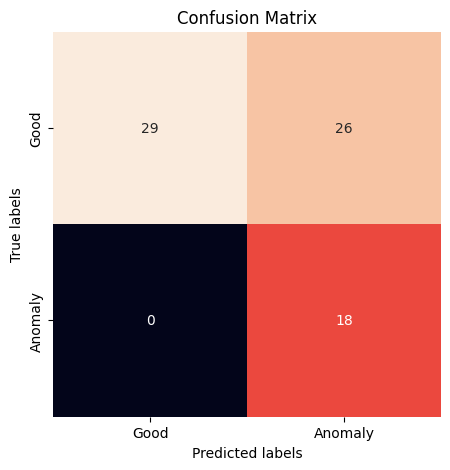

In [32]:
# Get the cross-validation folds using the get_cv_train_test_loaders() function with the root, batch_size, and n_folds parameters.
cv_folds = get_cv_train_test_loaders(
    root=data_folder,
    batch_size=batch_size,
    n_folds=n_cv_folds,
)

# Convert the class weights to a tensor and move it to the device.
class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)

# Define the loss function with the class weights as a CrossEntropyLoss criterion.
criterion = nn.CrossEntropyLoss(weight=class_weight)

# Loop through each cross-validation fold and train, evaluate, and print the performance of the model.
for i, (train_loader, test_loader) in enumerate(cv_folds):
    print(f"Fold {i+1}/{n_cv_folds}")
    model = CustomVGG()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = train(train_loader, model, optimizer, criterion, epochs, device)
    evaluate(model, test_loader, device)

### Visualization

Visualization is an easier way to understand the results obtained. 

Here, you can see that predicted as well as the true labels for each of the images along with the prediction of the likelihood of a positive outcome known as Probability(*Prob*) have been displayed above with the images. 

After the model gets trained, The images get classified as '*Good*' or '*Anomaly*'.

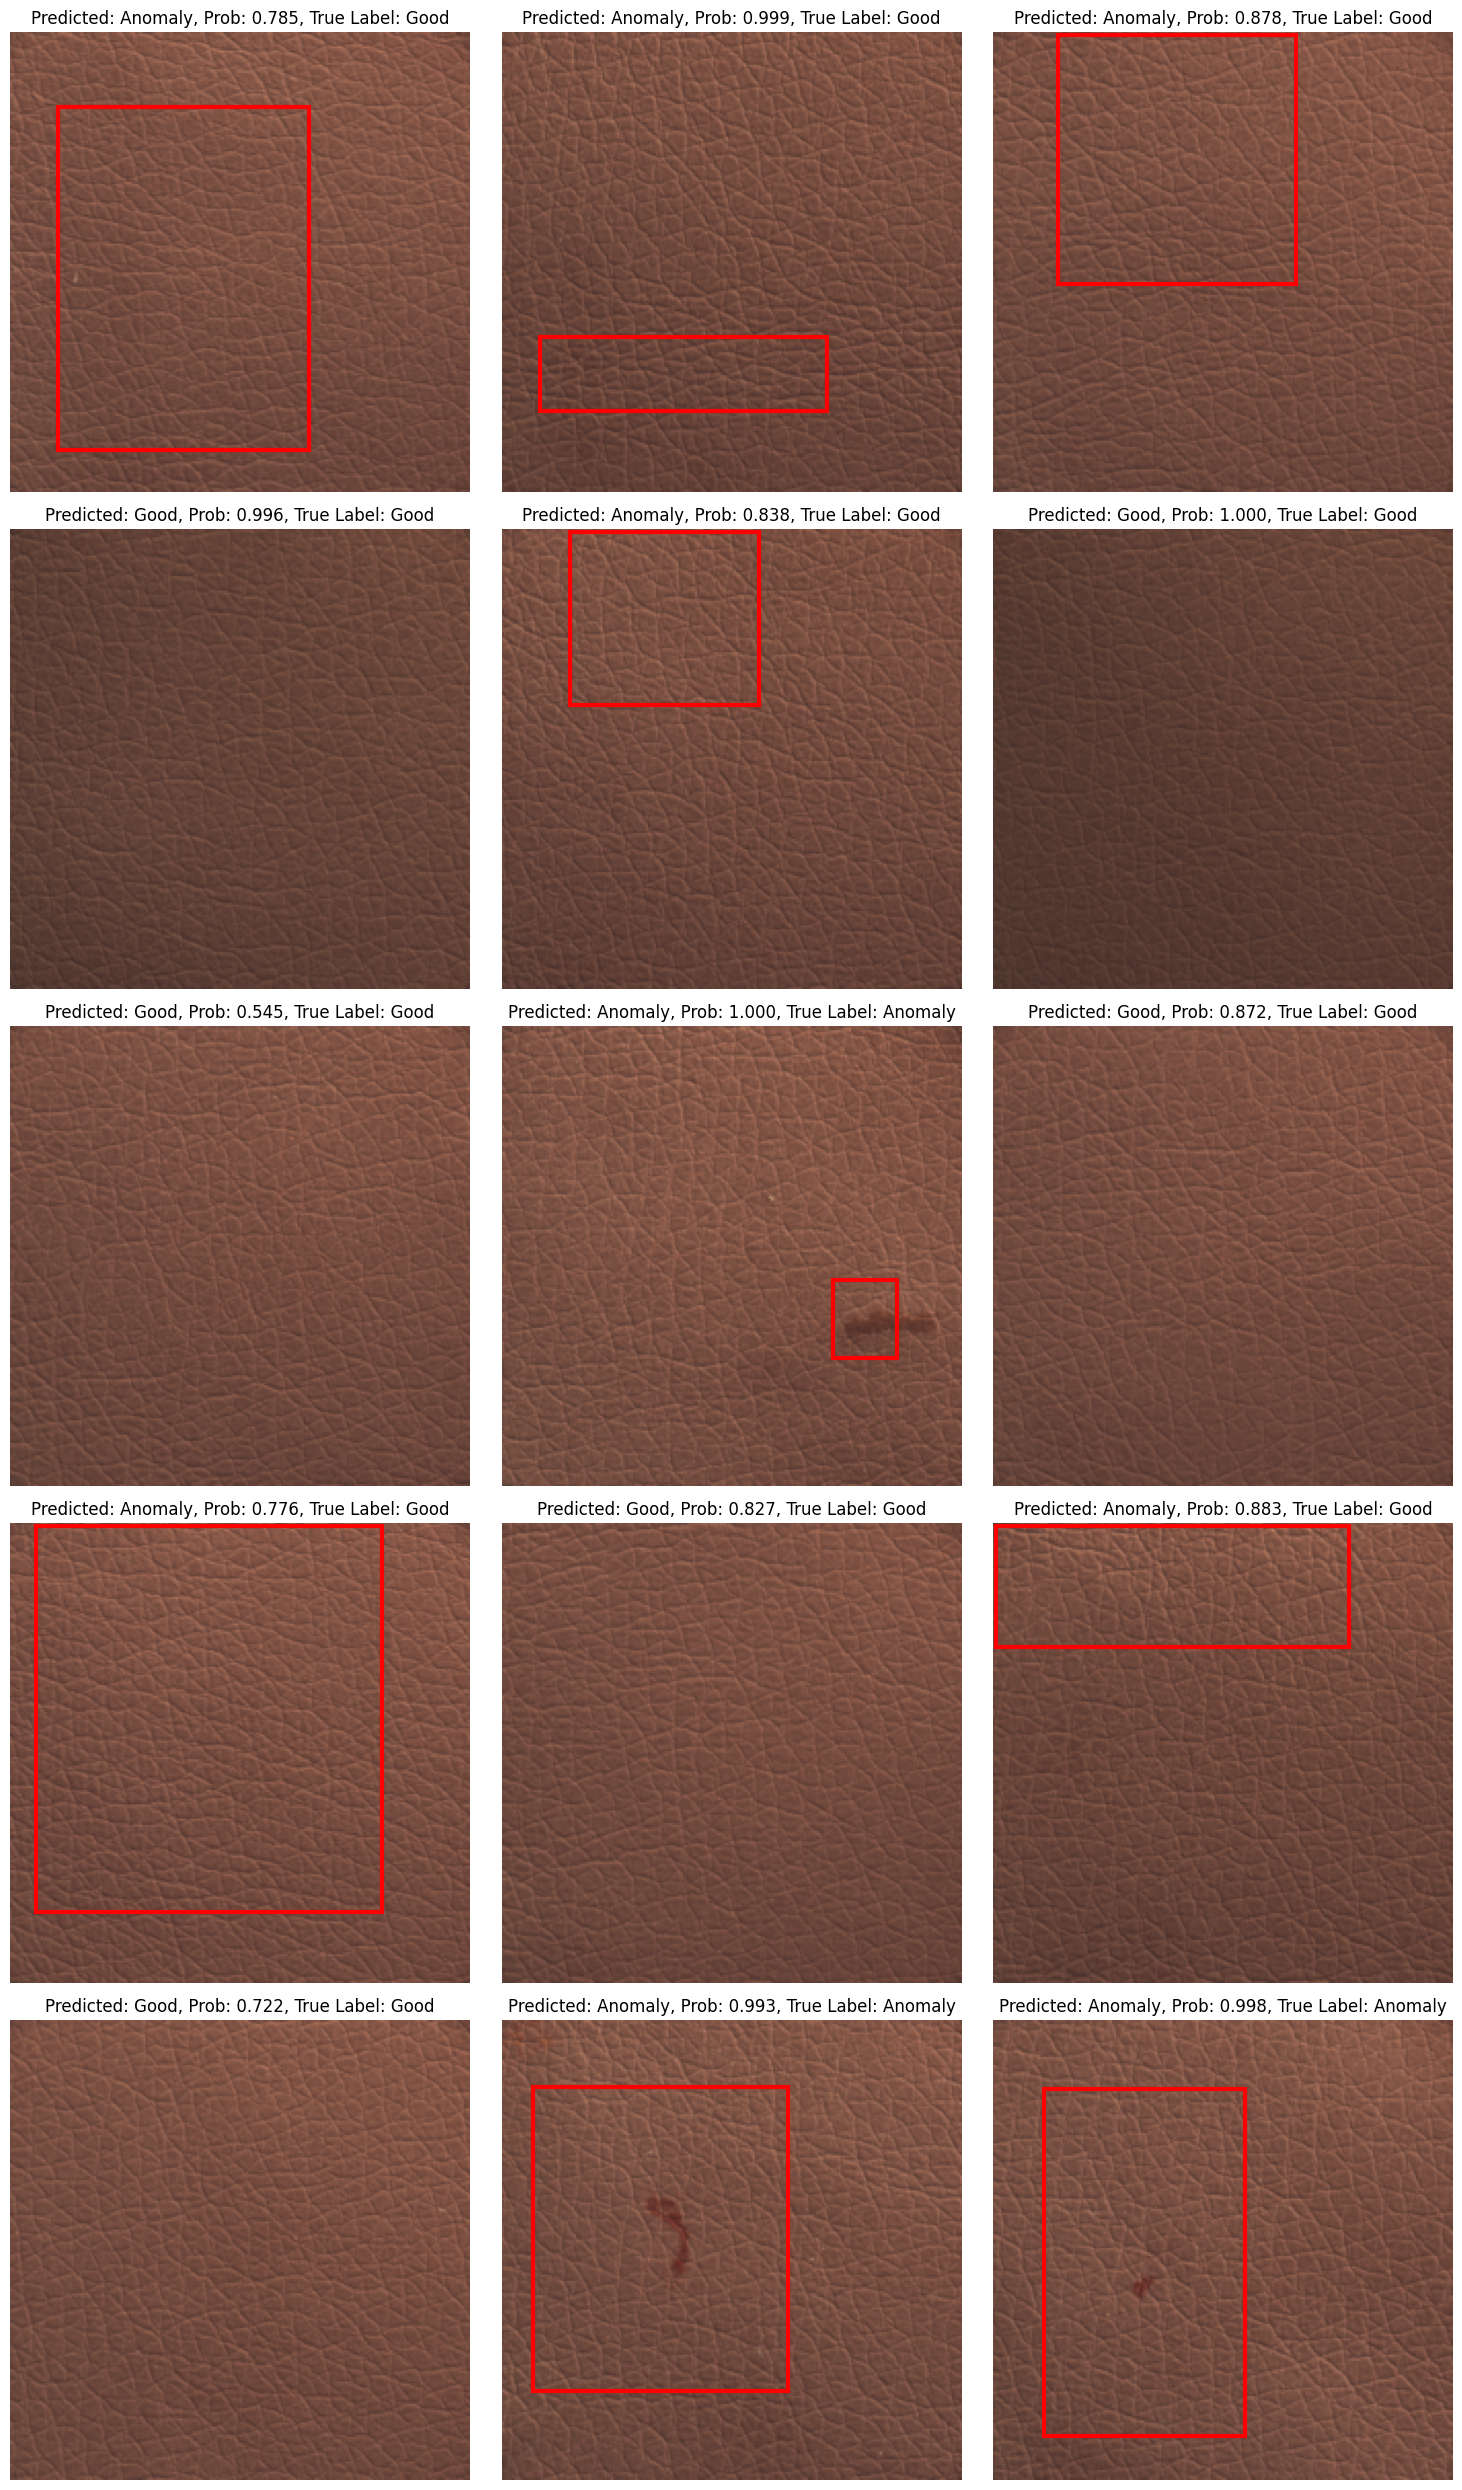

In [33]:
# Make predictions and localize the anomalies for the test dataset using the predict_localize() function with the model, test_loader, device, thres, n_samples, and show_heatmap parameters.
predict_localize(
    model, test_loader, device, thres=heatmap_thres, n_samples=15, show_heatmap=False
)